In [63]:
%load_ext autoreload
%autoreload 2

from src.data import load_data
from src.plots import *
from src.functions import *
import pandas as pd
import holidays
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Trend and Moving Averages

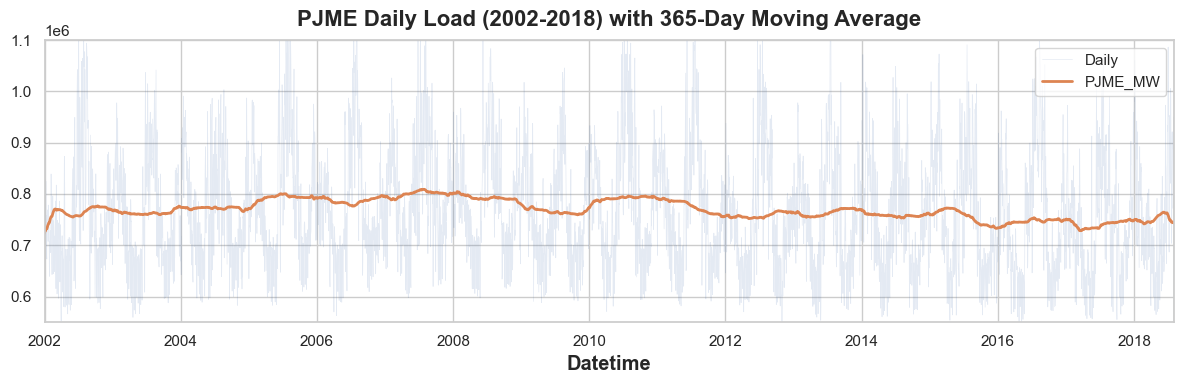

In [54]:
trends = load_data(to_period=True)

moving_average_year = trends.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = trends["PJME_MW"].plot(figsize=(12,4), alpha=0.15, lw=0.5, label="Daily")
moving_average_year.plot(ax=ax, lw=2, label="365-day MA")
ax.set_title("PJME Daily Load (2002-2018) with 365-Day Moving Average")
ax.set_ylim(550000, 1100000)  # optional zoom
ax.legend()
plt.savefig("../reports/figures/365-day-MA.png")

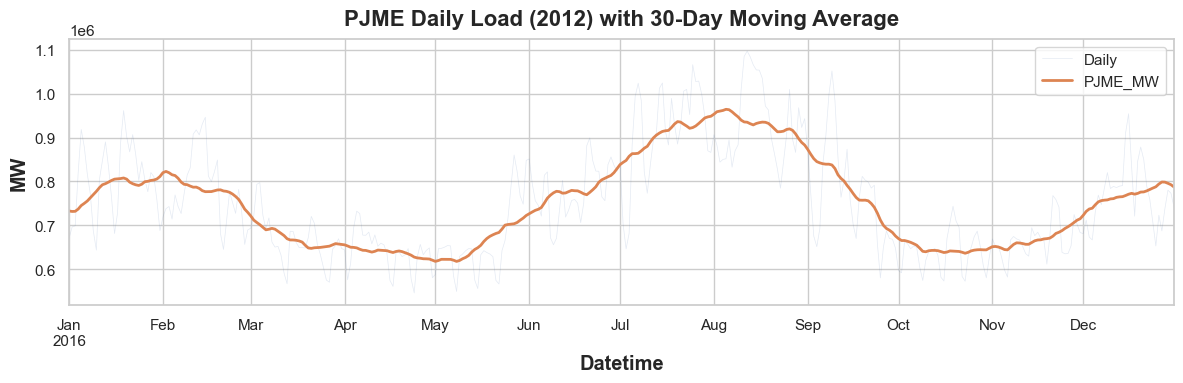

In [55]:
moving_average_month = trends.rolling(
    window=30,
    center=True,
    min_periods=15,
).mean()

ax = trends["PJME_MW"].loc["2016-01":"2016-12"].plot(figsize=(12,4), alpha=0.15, lw=0.5, label="Daily")
moving_average_month.loc["2016-01":"2016-12"].plot(ax=ax, lw=2, label="30-day MA")
ax.set_title("PJME Daily Load (2012) with 30-Day Moving Average")
ax.set_ylabel("MW")
ax.legend()
plt.savefig("../reports/figures/30-day-MA.png")

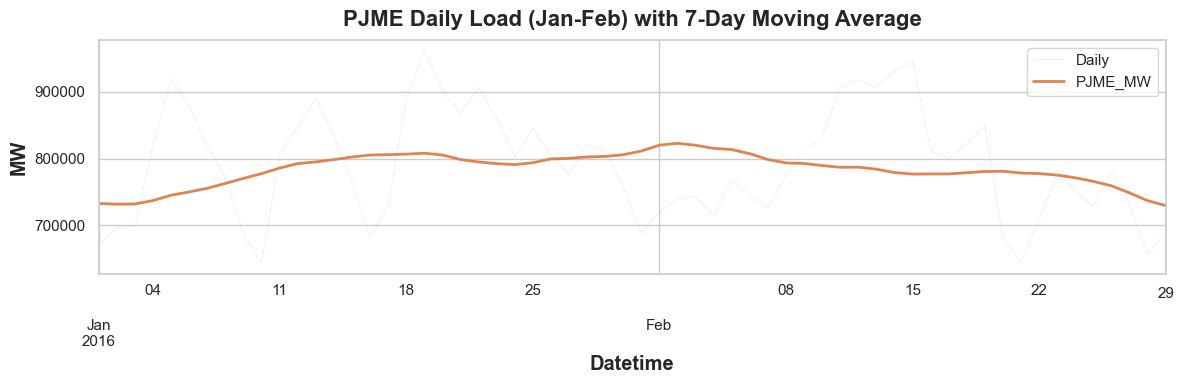

In [56]:
moving_average_week = trends.rolling(
    window=7,
    center=True,
    min_periods=3,
).mean()

ax = trends["PJME_MW"].loc["2016-01":"2016-02"].plot(figsize=(12,4), alpha=0.15, lw=0.5, label="Daily")
moving_average_month.loc["2016-01":"2016-02"].plot(ax=ax, lw=2, label="7-day MA")
ax.set_title("PJME Daily Load (Jan-Feb) with 7-Day Moving Average")
ax.set_ylabel("MW")
ax.legend()
plt.savefig("../reports/figures/7-day-MA.png")

# Let's add Fourier features

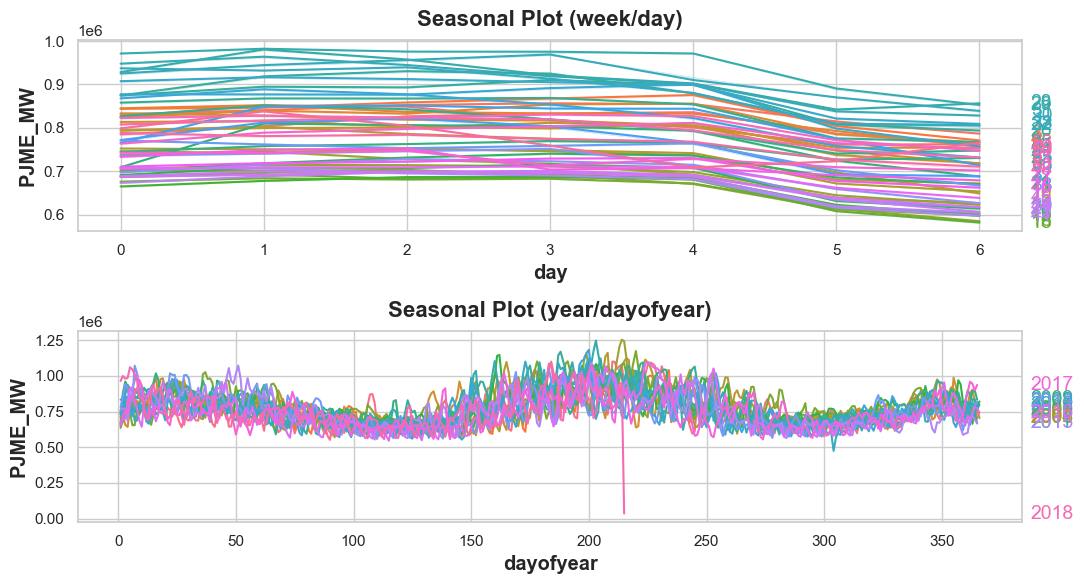

In [116]:
X = load_data(to_period=True)

# days within a week
X['day'] = X.index.dayofweek
X['week'] = X.index.week

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="PJME_MW", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="PJME_MW", period="year", freq="dayofyear", ax=ax1)
plt.savefig("../reports/figures/seasonal_plots.png")

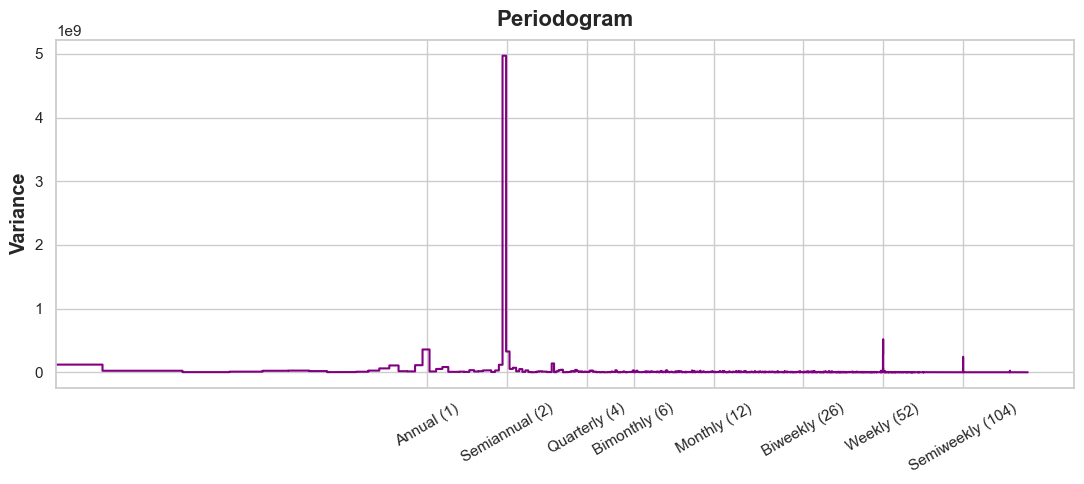

In [117]:
plot_periodogram(X.PJME_MW)
plt.savefig("../reports/figures/periodogram.png")

Periodogram shows huge spike at semiannual and noticeable variance at annual and weekly

## Pipeline to create deterministic/fourier features:

In [103]:
y = load_data(to_period=True)

train_start="2002-01-01"
train_end="2016-12-31"
test_start = "2017-01-01"
test_end = "2018-08-03"

dp, X_dp, det_model, y_fit, resid_fit, X_dp_train = make_deterministic_features(y, order=2, fourier_order=5, train_start=train_start, train_end=train_end)

y_train = y[train_start:train_end]
y_test = y[test_start:test_end]

X_dp_test = X_dp[test_start:test_end]
y_pred = pd.DataFrame(det_model.predict(X_dp_test), index=X_dp_test.index)

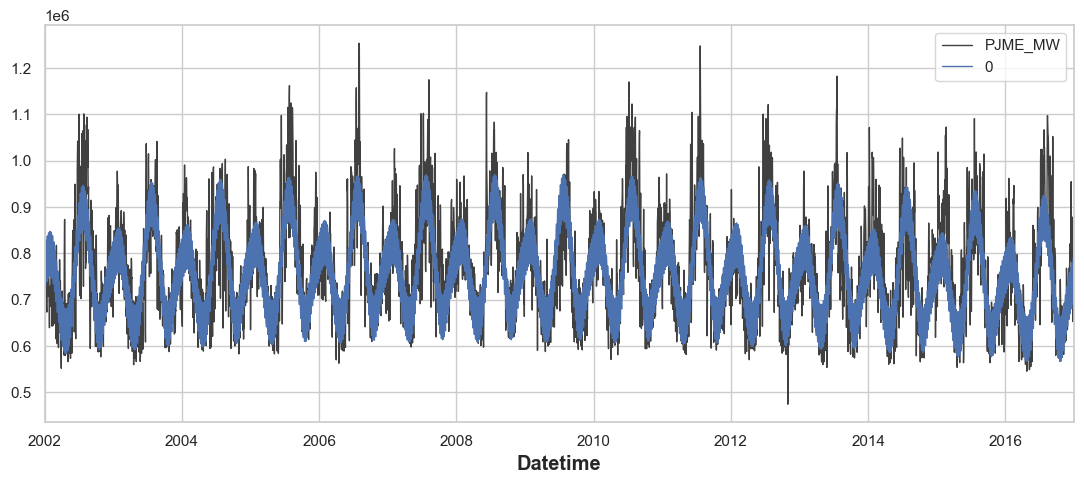

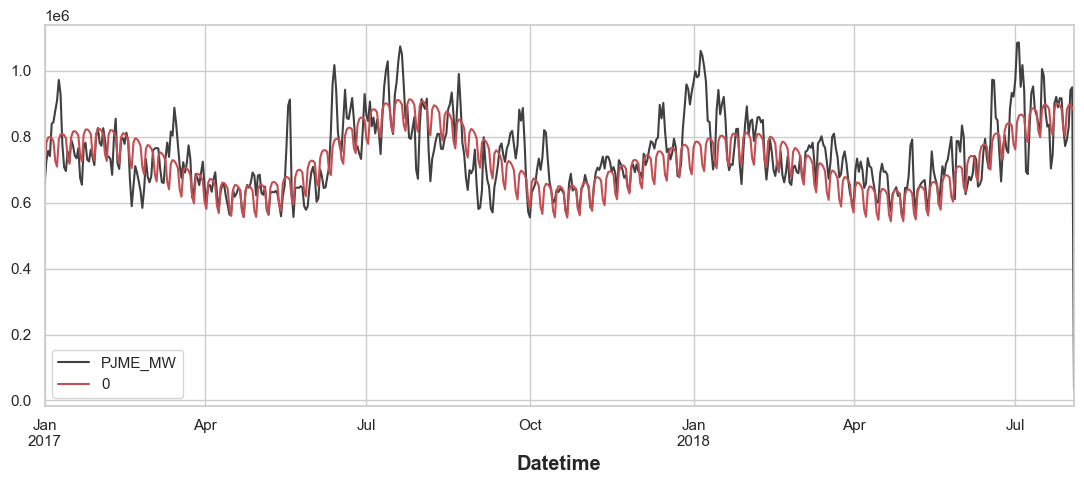

In [104]:

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True, linewidth=1)
axs1 = y_test.plot(color='0.25', subplots=True, sharex=True)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs, linewidth=1)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs1)


### Next, create residual features

In [105]:
y = load_data(to_period=True)


# calendar features
calendar_df = pd.DataFrame(index=y.index)
calendar_df["dow"] = y.index.dayofweek        # 0=Mon, 6=Sun
calendar_df["is_weekend"] = (calendar_df["dow"] >= 5).astype(int)
calendar_df["month"] = y.index.month


# holiday?

us_holidays = holidays.US(years=range(y.index.min().year, y.index.max().year+1))

holiday_flags = pd.Series(
    y.index.to_timestamp().normalize().isin(us_holidays),
    index=y.index
).astype(int)

holiday_df = pd.DataFrame({"is_holiday": holiday_flags})

X_resid_full = make_residual_features(y, calendar_df=calendar_df, holidays=us_holidays)